# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Выведем первые 5 строк каждого датафрейма и посмотрим информацию

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.head(5))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
internet = pd.read_csv('/datasets/internet.csv')
print(internet.head(5))
internet.info()

   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [4]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.head(5))
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
print(tariffs.head(5))
tariffs.info()

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [6]:
users = pd.read_csv('/datasets/users.csv')
users.head(5)


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Рассмотрим датафрейм с пользователями внимательнее. тут возмодны ошибки.

In [7]:
print(users['age'].unique())

[52 41 59 23 68 67 21 65 63 24 26 44 38 36 64 58 73 71 61 72 42 56 32 62
 20 51 28 66 31 37 47 40 69 48 33 39 43 46 45 55 53 34 49 25 18 70 50 19
 54 60 29 27 74 22 30 75 57 35]


In [8]:
print(users['city'].unique())

['Краснодар' 'Москва' 'Стерлитамак' 'Новокузнецк' 'Набережные Челны'
 'Ульяновск' 'Челябинск' 'Пермь' 'Тюмень' 'Самара' 'Санкт-Петербург'
 'Иваново' 'Чебоксары' 'Омск' 'Уфа' 'Томск' 'Чита' 'Мурманск'
 'Петрозаводск' 'Тверь' 'Екатеринбург' 'Махачкала' 'Вологда' 'Череповец'
 'Ярославль' 'Сочи' 'Хабаровск' 'Ставрополь' 'Рязань' 'Улан-Удэ' 'Тула'
 'Саратов' 'Ростов-на-Дону' 'Казань' 'Иркутск' 'Курск' 'Калуга' 'Якутск'
 'Астрахань' 'Химки' 'Владикавказ' 'Волгоград' 'Саранск' 'Ижевск'
 'Новосибирск' 'Брянск' 'Тольятти' 'Нижний Тагил' 'Орёл' 'Белгород'
 'Воронеж' 'Волжский' 'Курган' 'Барнаул' 'Красноярск' 'Архангельск'
 'Липецк' 'Кемерово' 'Киров' 'Сургут' 'Пенза' 'Магнитогорск'
 'Нижний Новгород' 'Кострома' 'Владивосток' 'Тамбов' 'Балашиха'
 'Севастополь' 'Калининград' 'Оренбург' 'Смоленск' 'Нижневартовск'
 'Владимир' 'Новороссийск' 'Грозный' 'Подольск']


Видим, что нужно гдето-нужно поменять тип данных, в таблице users есть пропуски. Но в целом данные хорошие.

## Предобработка данных

Изменим типы данных на более корректные

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Пропусков нигде нет, кроме users['churn_date'], но тут те пользователи, которые еще на этом тарифе

Округлим минуты в большуюс сторону

In [10]:
calls['duration'] = np.ceil(calls['duration'])

Посторим гистограммы времени звонка и использования интернета

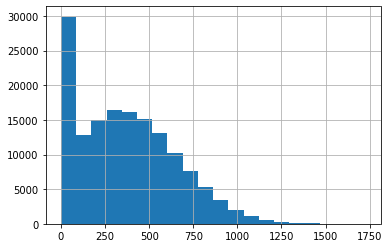

In [11]:
internet['mb_used'].hist(bins=20)

Видим, что многие пользователи не пользуются интернетом

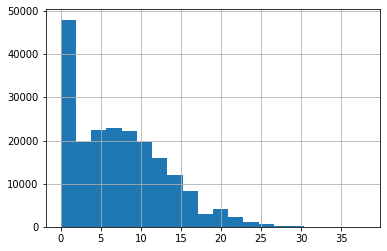

In [12]:
calls['duration'].hist(bins=20)

Видим, что много значений с 0, но эти звонки считаются пропущенными

## Подготовка данных

Сгруппируем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [13]:
calls['month'] = calls['call_date'].dt.month

In [14]:
calls_users = calls.pivot_table(index=('user_id', 'month'), values='duration', aggfunc=('sum', 'count')).reset_index()

Сгруппируем количество отправленных сообщений по месяцам

In [15]:
messages['month'] = messages['message_date'].dt.month

In [16]:
messages_users = messages.pivot_table(index=('user_id', 'month'), values='id', aggfunc='count').reset_index()

Сгруппируем объем израсходованного интернет-трафика по месяцам

In [17]:
internet['month'] = internet['session_date'].dt.month

In [18]:
internet_users = internet.pivot_table(index=('user_id', 'month'), values='mb_used', aggfunc='sum').reset_index()

Округлим значения согласно тарифам Мегалайна

In [19]:
internet_users['mb_used'] =  (internet_users['mb_used'] / 1024).apply(math.ceil)
internet_users.columns = ['user_id', 'month', 'gb_used']

Объеденим таблиц с помощью merge и поменем названия столбцов

In [20]:
users_month = calls_users.merge(messages_users, on=['user_id', 'month'], how='outer').merge(internet_users, on=['user_id', 'month'], how='outer').merge(users[['user_id', 'tariff']], on='user_id')
users_month.columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'gb', 'tariff_name']
display(users_month.head(10))
users_month.info()

,user_id,month,calls,minutes,messages,gb,tariff_name
0,1000,5,22.0,159.0,22.0,3.0,ultra
1,1000,6,43.0,172.0,60.0,23.0,ultra
2,1000,7,47.0,340.0,75.0,14.0,ultra
3,1000,8,52.0,408.0,81.0,14.0,ultra
4,1000,9,58.0,466.0,57.0,15.0,ultra
5,1000,10,57.0,350.0,73.0,15.0,ultra
6,1000,11,43.0,338.0,58.0,15.0,ultra
7,1000,12,46.0,333.0,70.0,10.0,ultra
8,1001,11,59.0,430.0,NaN,18.0,smart
9,1001,12,63.0,414.0,NaN,14.0,smart


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id        3214 non-null int64
month          3214 non-null int64
calls          3174 non-null float64
minutes        3174 non-null float64
messages       2717 non-null float64
gb             3203 non-null float64
tariff_name    3214 non-null object
dtypes: float64(4), int64(2), object(1)
memory usage: 200.9+ KB


Заменим все пустые значение на 0, так как если их нет, значит клиент не пользовался этой услугой

In [21]:
users_month = users_month.fillna(value=0)

И приведем к парвильному типу данных

In [22]:
users_month['calls'] = users_month['calls'].astype('int')
users_month['messages'] = users_month['messages'].astype('int')
users_month['minutes'] = users_month['minutes'].astype('int')
users_month['gb'] = users_month['gb'].astype('int')

Переведем мегабайты в гигабайты и объеденим таблицу по тарифам

In [23]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs = tariffs.drop('mb_per_month_included', axis=1)

In [24]:
users_month = users_month.merge(tariffs, on='tariff_name')
display(users_month.head(10))

,user_id,month,calls,minutes,messages,gb,tariff_name,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5,22,159,22,3,ultra,1000,3000,1950,150,1,1,30.0
1,1000,6,43,172,60,23,ultra,1000,3000,1950,150,1,1,30.0
2,1000,7,47,340,75,14,ultra,1000,3000,1950,150,1,1,30.0
3,1000,8,52,408,81,14,ultra,1000,3000,1950,150,1,1,30.0
4,1000,9,58,466,57,15,ultra,1000,3000,1950,150,1,1,30.0
5,1000,10,57,350,73,15,ultra,1000,3000,1950,150,1,1,30.0
6,1000,11,43,338,58,15,ultra,1000,3000,1950,150,1,1,30.0
7,1000,12,46,333,70,10,ultra,1000,3000,1950,150,1,1,30.0
8,1003,8,55,380,37,9,ultra,1000,3000,1950,150,1,1,30.0
9,1003,9,134,961,91,13,ultra,1000,3000,1950,150,1,1,30.0


Создадим функцию, которые посчитает сколько платит каждый пользователь каждый месяц и с помощью apply создадим новый столбец

In [25]:
def calculation(users_month):
    money = users_month['rub_monthly_fee']
    minutes = users_month['minutes_included'] - users_month['minutes']
    messages = users_month['messages_included'] - users_month['messages']
    mb = users_month['gb_per_month_included'] - users_month['gb']
    if minutes < 0:
        money += abs(minutes) * users_month['rub_per_minute']
    if messages < 0:
        money += abs(messages) * users_month['rub_per_message']
    if mb < 0:
        money += abs(mb) * users_month['rub_per_gb']
    return money

In [26]:
users_month['income'] = users_month.apply(calculation, axis=1)

## Анализ данных

Посмотрим на самые прибыльные месяцы

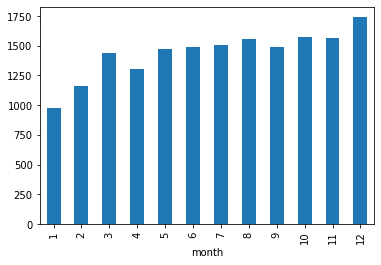

In [27]:
users_month.groupby('month')['income'].mean().plot(kind='bar')
plt.show()

Средний доход от каждого пользовател ровные на протжении всего года, но в декабре большой подъем, а в январе и феврале спад.

Построим гистограммы по количеству минут, сообщений и интернета в месяц для обоих тарифов

In [28]:
smart = users_month.query('tariff_name == "smart"')
ultra = users_month.query('tariff_name == "ultra"')

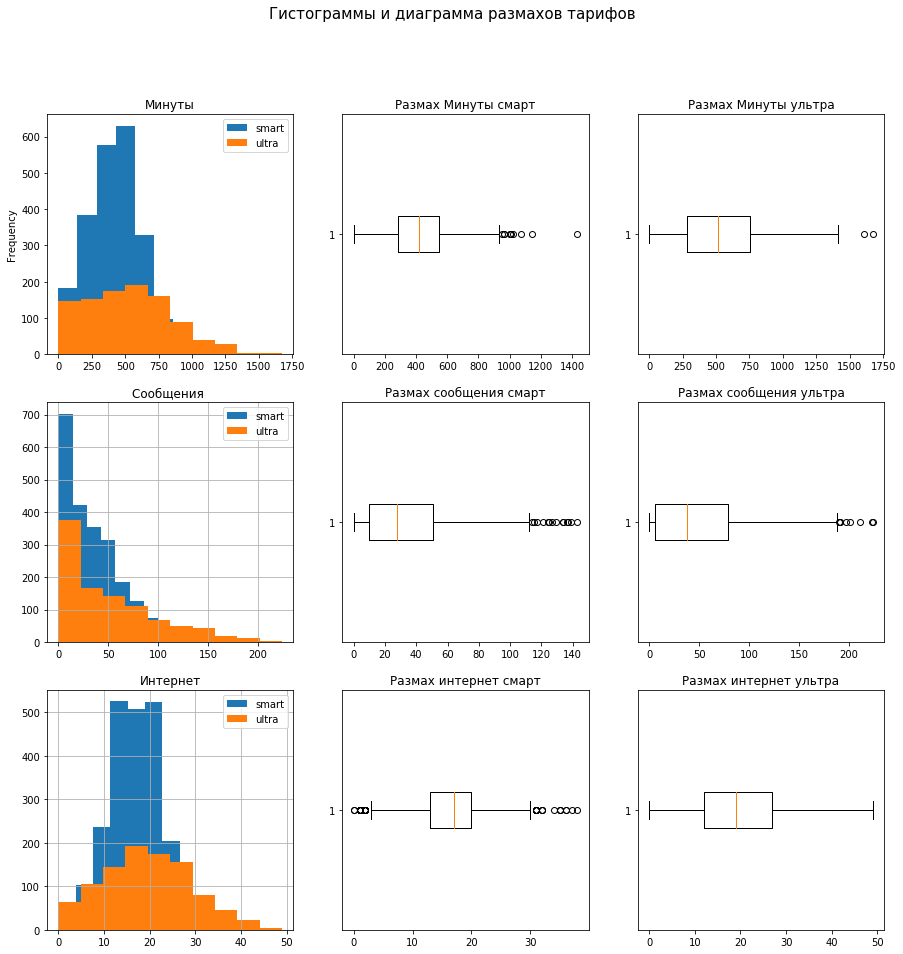

In [29]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Гистограммы и диаграмма размахов тарифов', fontsize=15)

plt.subplot(3, 3, 1).set_title('Минуты')
smart['minutes'].plot(kind='hist', bins=10)
ultra['minutes'].plot(kind='hist', bins=10)
plt.legend(['smart', 'ultra'])

plt.subplot(3, 3, 2).set_title('Размах Минуты смарт')
plt.boxplot('minutes', data=smart, vert=False)

plt.subplot(3, 3, 3).set_title('Размах Минуты ультра')
plt.boxplot('minutes', data=ultra, vert=False)

plt.subplot(3, 3, 4).set_title('Сообщения ')
smart['messages'].hist(bins=10)
ultra['messages'].hist(bins=10)
plt.legend(['smart', 'ultra'])

plt.subplot(3, 3, 5).set_title('Размах сообщения смарт')
plt.boxplot('messages', data=smart, vert=False)

plt.subplot(3, 3, 6).set_title('Размах сообщения ультра')
plt.boxplot('messages', data=ultra, vert=False)

plt.subplot(3, 3, 7).set_title('Интернет')
smart['gb'].hist(bins=10)
ultra['gb'].hist(bins=10)
plt.legend(['smart', 'ultra'])

plt.subplot(3, 3, 8).set_title('Размах интернет смарт')
plt.boxplot('gb', data=smart, vert=False)

plt.subplot(3, 3, 9).set_title('Размах интернет ультра')
plt.boxplot('gb', data=ultra, vert=False)

plt.show()

Распределение минуты ультра скошено в отрицательную сторону. Минуты смарт, Интернет смарт и Интерне ультра имеют нормальное распределение.
Видим, что на тарифе ультра используется в среднем больше минут. Но много людей мало разгвоаривают на этом тарифе. На тарифе смарт в оснвном люди тратят от 200 до 400 минут в месяц. На обоих гистограммах по смс видим, что очень многие пользователи отправляют мало смс или не отправляют их вообще. Но на тарифе ультра отправляют больше. На смарте есть пользователи которые практически не пользуются интернетом, а в срднем используют в районе лимита тарифа. На ультра используют интрнет намного больше. В основном от 10 до 30 гб. На всех диаграммах размаха видим, что выбросов очень мало.

Посчитаем среднее для обоих тарифов, дисперсию и стандартное отклонение

In [30]:
def analysis(data):
    print('Среднее минуты', data['minutes'].mean())
    print('Дисперсия минуты', np.var(data['minutes'], ddof=1))
    print('Стандартное отклонение минуты', np.std(data['minutes'], ddof=1))
    print('Среднее сообщения', data['messages'].mean())
    print('Дисперсия сообщения', np.var(data['messages'], ddof=1))
    print('Стандартное отклонение сообщения', np.std(data['messages'], ddof=1))
    print('Среднее интернет', data['gb'].mean())
    print('Дисперсия интернет', np.var(data['gb'], ddof=1))
    print('Стандартное отклонение интернет', np.std(data['gb'], ddof=1))

In [31]:
analysis(smart)

Среднее минуты 417.9349484073576
Дисперсия минуты 36219.31578434428
Стандартное отклонение минуты 190.31372988921288
Среднее сообщения 33.384028712427096
Дисперсия сообщения 796.8129584480083
Стандартное отклонение сообщения 28.22787555676141
Среднее интернет 16.328847016599372
Дисперсия интернет 33.02870517811161
Стандартное отклонение интернет 5.7470605685090534


In [32]:
analysis(ultra)

Среднее минуты 526.6233502538071
Дисперсия минуты 100873.63339730098
Стандартное отклонение минуты 317.6060978591264
Среднее сообщения 49.36345177664975
Дисперсия сообщения 2285.2661425446736
Стандартное отклонение сообщения 47.804457350174715
Среднее интернет 19.494416243654822
Дисперсия интернет 97.09168626965459
Стандартное отклонение интернет 9.853511367510293


На тарифе ультра используется в среднем больше минут. Но много людей мало разгвоаривают на этом тарифе. На тарифе смарт в оснвном люди тратят от 200 до 400 минут в месяц. На обоих гистограммах по смс видим, что очень многие пользователи отправляют мало смс или не отправляют их вообще. Но на тарифе ультра отправляют больше. На смарте есть пользователи которые практически не пользуются интернетом, а в срднем используют в районе лимита тарифа. На ультра используют интрнет намного больше. В основном от 10 до 30 гб. На всех диаграммах размаха видим, что выбросов очень мало. Кроме интернета на смарте. Видно, что есть люди, которые практически не пользуются интернетом.

## Проверка гипотез

Выведем гистограммы выручки для обоих тарифов

Среднее значение Смарт: 1289.9735307312696
Среднее значение Ультра: 2070.1522842639592


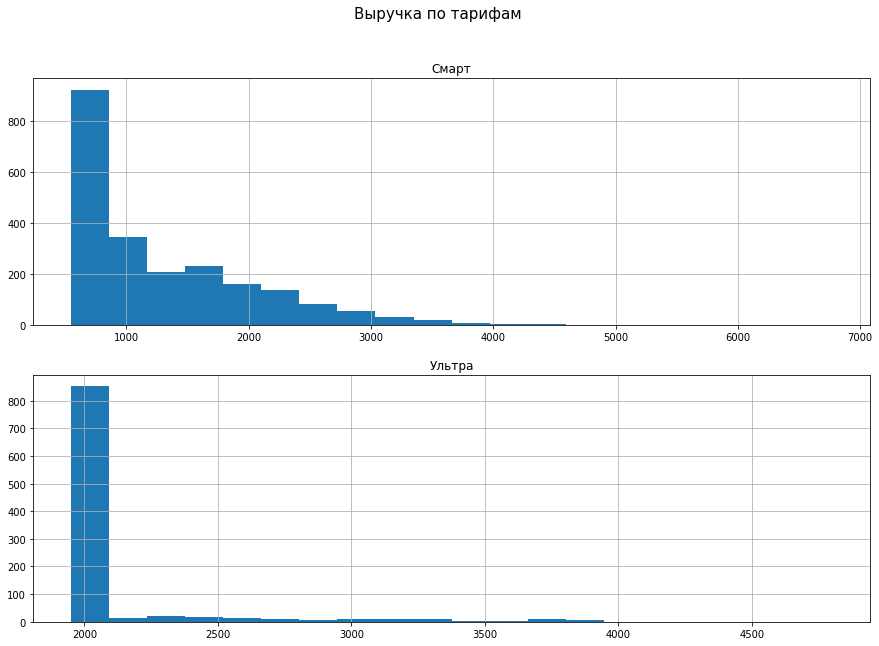

In [33]:
s_income = smart['income'].mean()
print('Среднее значение Смарт:', s_income)
u_income = ultra['income'].mean()
print('Среднее значение Ультра:', u_income)
fig2 = plt.figure(figsize=(15,10))
fig2.suptitle('Выручка по тарифам', fontsize=15)
i1 = plt.subplot(2, 1, 1).set_title('Смарт')
i1 = smart['income'].hist(bins=20)
i2 = plt.subplot(2, 1, 2).set_title('Ультра')
i2 = ultra['income'].hist(bins=20)

Видим, что среднее значение отличается у двух тарифах. По гистограммам видно, что в основном на смарте плятят до 1000 рублей в месяц, а на ультра около 2000.

Сравним доходы от тарифов по нулевой гипотезе. Сформулируем ее так: 'Средние выручки от пользователей разных тарифов равны'. Следовательно альтернативная гипотеза будет: 'Средние выручки от пользователей разных тарифов различаются'

In [34]:
np.var(ultra['income'], ddof=1)

141516.7450786183

In [35]:
np.var(smart['income'], ddof=1)

669785.7080064242

Дисперсии отличаются, следовательно зададим параметр equal_var=False

In [36]:
alpha = 0.05
results = st.ttest_ind(ultra['income'], smart['income'], equal_var=False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, следовательно средние выручки от пользователей разных тарифов различаются

Теперь проверим средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Добавим в нашу таблицу информацию про города пользователей

In [37]:
users_month = users_month.merge(users[['user_id', 'city']], on='user_id', how='outer')
users_month = users_month.dropna()

Среднее значение Москва: 1524.9362274298885
Среднее значение Другие: 1546.7135842880523


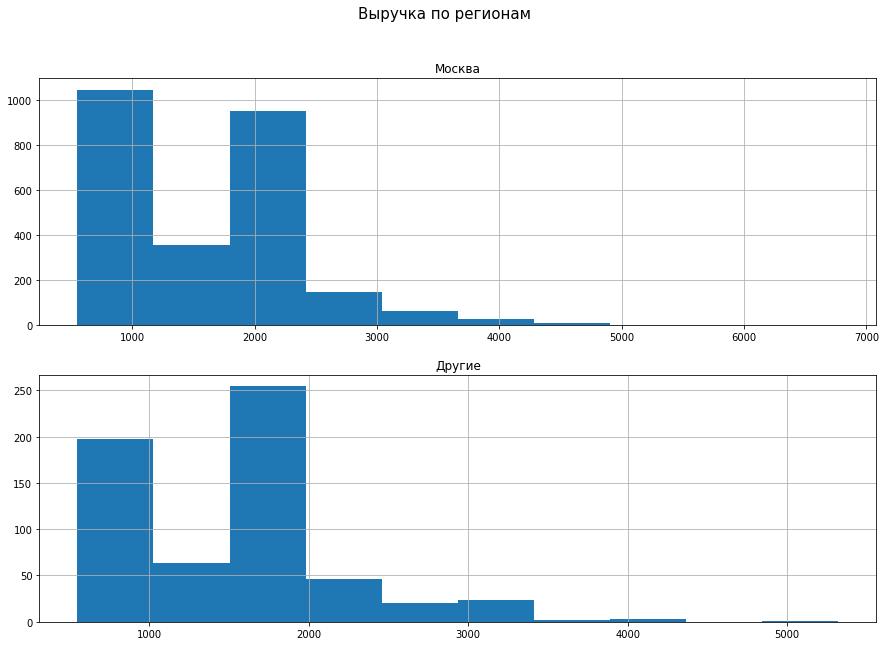

In [38]:
m_income = users_month.query('city != "Москва"')['income'].mean()
print('Среднее значение Москва:', m_income)
o_income = users_month.query('city == "Москва"')['income'].mean()
print('Среднее значение Другие:', o_income)
fig3 = plt.figure(figsize=(15,10))
fig3.suptitle('Выручка по регионам', fontsize=15)
m1 = plt.subplot(2, 1, 1).set_title('Москва')
m1 = users_month.query('city != "Москва"')['income'].hist(bins=10)
o2 = plt.subplot(2, 1, 2).set_title('Другие')
o2 = users_month.query('city == "Москва"')['income'].hist(bins=10)

По гистограммам и среднему видим, что разницы практически нет, но проверим это с помощью гипотезы.

Сформулируем нулевую гипотезу - средние выручки ползователей из Москвы и из других городов равны. Альтернативная - Средние выручки ползователей из Москвы и из других регионов различаются.

In [39]:
alpha = 0.05
results = st.ttest_ind(users_month.query('city != "Москва"')['income'], users_month.query('city == "Москва"')['income'])
print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value:  0.5440152911670224
Не отвергаем нулевую гипотезу


Нельзя отвергнуть, что средние выручки пользователей из Москвы и из других регионов равны. С вероятностью в 58% различия получаются случайно.

Теперь посмотрим какой тариф приносит больше денег

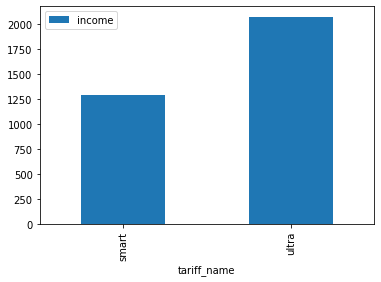

In [40]:
users_month.pivot_table(index='tariff_name', values='income', aggfunc='mean').plot(kind='bar')

Средний доход от пользователей ултьра больше. Посмотрим на количество измерений на каждом тарифе

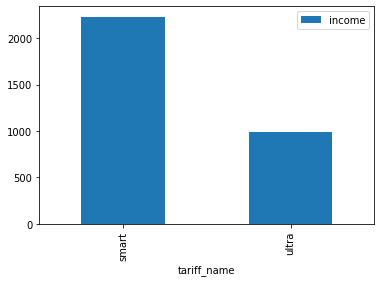

In [41]:
users_month.pivot_table(index='tariff_name', values='income', aggfunc='count').plot(kind='bar')

Пользователей на тарифе смарт в 2 раза больше. Теперь посмотрим общую прибуль на каждом тарифе

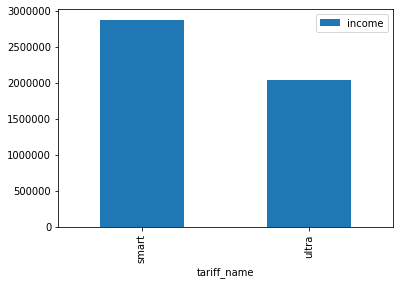

In [42]:
users_month.pivot_table(index='tariff_name', values='income', aggfunc='sum').plot(kind='bar')

Видим, что хоть средний доход на тарифе ультра больше, но за счет того, что на тарифе смарт намного больше ползователей, этот тариф приносит больше прибыли. Но так как средний доход с тарифа ультра больше, нужно вложиться в его рекламу.

In [43]:
np.var(ultra['income'])

141373.07325620347

In [44]:
np.var(smart['income'])

669485.2209234245

Сформиурем нулевую гипотезу - доход с тарифиов не различается. Альтернативная - Доход на тарифе ултьра больше, чем на тарифе смарт

In [45]:
alpha = 0.05
results = st.ttest_ind(smart['income'], ultra['income'], equal_var=False)
print('p-value: ', results.pvalue)
if (results.pvalue / 2 < alpha) and (ultra['income'].mean() > smart['income'].mean()):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, следовательно на тарифе ультра доход больше

## Вывод

В целом нам предоставили хорошие данные. Построив гистограммы  по расходу на разных тарифах в месяц можно сделать выводы, что распределение минуты ультра скошено в отрицательную сторону. Минуты смарт, Интернет смарт и Интерне ультра имеют нормальное распределение. Видим, что на тарифе ультра используется в среднем больше минут. Но много людей мало разгвоаривают на этом тарифе. На тарифе смарт в оснвном люди тратят от 200 до 400 минут в месяц. На обоих гистограммах по смс видим, что очень многие пользователи отправляют мало смс или не отправляют их вообще. Но на тарифе ультра отправляют больше. На смарте есть пользователи которые практически не пользуются интернетом, а в среднем используют в районе лимита тарифа. На ультра используют интрнет намного больше. В основном от 10 до 30 гб. Проверив нулевую гипотезу установии, что средние выручки от пользователей разных тарифов различаются и нельзя отвергнуть, что средние выручки ползователей из Москвы и из других регионов равны. С вероятностью в 58% различия получаются случайно. Хоть средний доход на тарифе ультра больше, но за счет того, что на тарифе смарт намного больше ползователей, этот тариф приносит больше прибыли. Но так как средний доход с тарифа ультра больше, нужно вложиться в его рекламу.